In [20]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

%matplotlib inline

In [21]:
output_paths = ['results-8-15.csv', 'results-15-all.csv', 'results-evosuite.csv']
data: pd.DataFrame = None
for output_path in output_paths:
    tmp = pd.read_csv(output_path)
    if data is None:
        data = tmp
    else:
        data = pd.concat([data, tmp])

In [22]:
data['project'] = data['benchmark'].apply(lambda x: x[:x.rindex('-')])
data = data[data['project'] != 'FASTJSON']
data = data[data['run_number'] == 1]

In [23]:
data_indexed = data.set_index(['tool', 'timeout', 'project'], drop=False).sort_index()

In [24]:
def get_weighted_stats(x, w=None, mn=None, mx=None, **kwargs):
    stats = DescrStatsW(x, w, ddof=1)

    q1, q2, q3 = stats.quantile([0.25, 0.5, 0.75], return_pandas=False)
    iqr = q3 - q1

    whishi = q3 + 1.5 * iqr
    if mx is not None:
        whishi = min(mx, whishi)

    whislo = q1 - 1.5 * iqr
    if mn is not None:
        whislo = max(mn, whislo)

    fliers = x.loc[(x > whishi) | (x < whislo)]

    return {
        'mean': stats.mean,
        'q1': q1,
        'med': q2,
        'q3': q3,
        'iqr': iqr,
        'whishi': whishi,
        'whislo': whislo,
        'fliers': list(fliers),
        'std': stats.std,
        **kwargs
    }


In [25]:
tools = list(data_indexed.index.unique(0))
timeouts = list(data_indexed.index.unique(1))
projects = list(data_indexed.index.unique(2))

In [26]:
def full_stats_dict():
    return {
        'default': None,
        'weighted': None,
    }


def compute_stats_by(df: pd.DataFrame, name: str, mod: str, weighted: bool) -> dict:
    label = f'{name}_{mod}'
    if weighted:
        label += ' (w)'
    return get_weighted_stats(
        df[f'{name}_{mod}_ratio'],
        df[f'{name}_total'] if weighted else None,
        mn=0, mx=100,
        label=label
    )


def compute_stats(df: pd.DataFrame, weighted: bool) -> dict:
    return {
        'lines_coverage': compute_stats_by(df, 'lines', 'coverage', weighted),
        'branches_coverage': compute_stats_by(df, 'branches', 'coverage', weighted),
        'mutants_coverage': compute_stats_by(df, 'mutants', 'coverage', weighted),
        'mutants_killed': compute_stats_by(df, 'mutants', 'killed', weighted),
    }


global_stats = defaultdict(
    lambda: defaultdict(
        lambda: {
            'projects': defaultdict(lambda: full_stats_dict()),
            **full_stats_dict()
        }
    )
)

for tool in tools:
    for timeout in timeouts:
        dt = data_indexed.loc[tool, timeout]
        stats = global_stats[tool][timeout]
        stats['default'] = compute_stats(dt, weighted=False)
        stats['weighted'] = compute_stats(dt, weighted=True)

        stats = stats['projects']
        for project in projects:
            dt = data_indexed.loc[tool, timeout, project]
            p_stats = stats[project]
            p_stats['default'] = compute_stats(dt, weighted=False)
            p_stats['weighted'] = compute_stats(dt, weighted=True)

In [37]:
table = pd.DataFrame(
    index=pd.MultiIndex.from_product([['ALL'] + projects, timeouts, tools], names=['project', 'timeout', 'tool']),
    columns=['lines', 'branches', 'mutants', 'mutants_killed', 'lines (w)', 'branches (w)', 'mutants (w)',
             'mutants_killed (w)']
)


def extract(x):
    return [x['lines_coverage']['mean'], x['branches_coverage']['mean'], x['mutants_coverage']['mean'],
            x['mutants_killed']['mean']]


for timeout in timeouts:
    for tool in tools:
        stats = global_stats[tool][timeout]
        item = [*extract(stats['default']), *extract(stats['weighted'])]
        table.loc['ALL', timeout, tool] = item
        for project in projects:
            stats = global_stats[tool][timeout]['projects'][project]
            item = [*extract(stats['default']), *extract(stats['weighted'])]
            table.loc[project, timeout, tool] = item

table.loc[:, 120, :]

lines   branches    mutants mutants_killed  \
project tool                                                            
ALL     evokex-15-all  53.147012  46.426465  22.240995      22.047758   
        evokex-8-15    56.030958  51.634905  31.380947       31.18771   
        evosuite-mo    60.378223  53.766822  32.743273      32.550036   
GUAVA   evokex-15-all  52.006308   49.35816  36.814182      36.234472   
        evokex-8-15    66.803001  61.921134  59.435769      58.856059   
        evosuite-mo    62.546936  56.863645  46.997621      46.417911   
SEATA   evokex-15-all  53.675787  46.161015  29.908803      29.908803   
        evokex-8-15    43.567386  40.425686  28.040404      28.040404   
        evosuite-mo    60.913795  54.094585  47.898864      47.898864   
SPOON   evokex-15-all  53.758941  43.760221        0.0            0.0   
        evokex-8-15    57.722488  52.557896   6.666667       6.666667   
        evosuite-mo    57.673939  50.342237   3.333333       3.333333   

                       lines (w) branches (w) mutants (w) mutants_killed (w)  
project tool                                                                  
ALL     evokex-15-all  39.255597    33.944954   29.868421          29.736842  
        evokex-8-15    42.977609    46.461337   43.196005          43.071161  
        evosuite-mo    51.177668     53.27654   49.569583          49.426111  
GUAVA   evokex-15-all   46.42857    45.212766   55.133615          54.852321  
        evokex-8-15    68.292682    75.531915   79.689521          79.430789  
        evosuite-mo     64.02439    71.631205   80.966324          80.673499  
SEATA   evokex-15-all  34.489051    28.436019   17.174516          17.174516  
        evokex-8-15    24.361314    19.905214    14.39206           14.39206  
        evosuite-mo     40.60219    34.360189   35.156249          35.156249  
SPOON   evokex-15-all  36.736402    26.481482         0.0                0.0  
        evokex-8-15    35.732218    36.851852    4.225352           4.225352  
        evosuite-mo    48.535565     48.88889    0.917431           0.917431

In [28]:
metrics = [
    'lines_coverage',
    'branches_coverage',
    'mutants_coverage',
    'mutants_killed',
]

print('tools:', ', '.join(tools))
print('timeouts:', ', '.join([str(x) for x in timeouts]))
print('projects:', ', '.join(projects))
print('metrics:', ', '.join(metrics))

tools: evokex-15-all, evokex-8-15, evosuite-mo
timeouts: 30, 60, 120
projects: GUAVA, SEATA, SPOON
metrics: lines_coverage, branches_coverage, mutants_coverage, mutants_killed


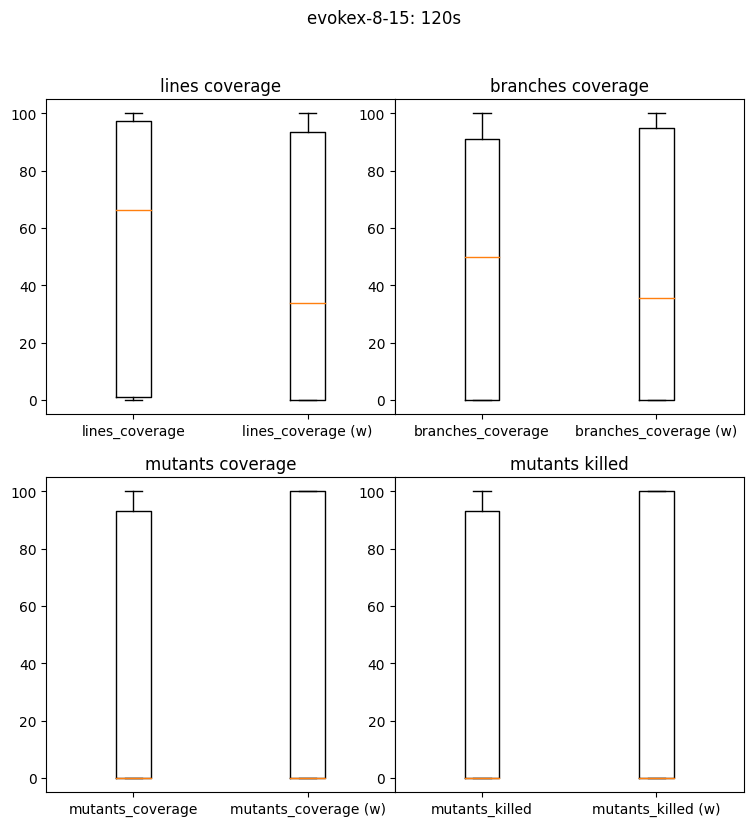

In [29]:
tool = 'evokex-8-15'
timeout = 120
project = None

fig = plt.figure(figsize=(9, 9))
gs = fig.add_gridspec(2, 2, wspace=0)
axes = gs.subplots()

fig.suptitle(f'{tool}: {timeout}s' if project is None else f'{tool}: {project} {timeout}s')

stats = global_stats[tool][timeout] if project is None else global_stats[tool][timeout]['projects'][project]

params = dict(
    widths = [0.2, 0.2],
)

axes[0][0].bxp([
    stats['default']['lines_coverage'],
    stats['weighted']['lines_coverage'],
], **params)
axes[0][0].set_title('lines coverage')

axes[0][1].bxp([
    stats['default']['branches_coverage'],
    stats['weighted']['branches_coverage'],
], **params)
axes[0][1].set_title('branches coverage')

axes[1][0].bxp([
    stats['default']['mutants_coverage'],
    stats['weighted']['mutants_coverage'],
], **params)
axes[1][0].set_title('mutants coverage')

axes[1][1].bxp([
    stats['default']['mutants_killed'],
    stats['weighted']['mutants_killed'],
], **params)
axes[1][1].set_title('mutants killed')

plt.show()

In [30]:
def get_cmap(n, name='brg'):
    return plt.colormaps.get_cmap(name).resampled(n)


def draw_boxplots(ax: plt.Axes, labels, mods, get_stats, width=0.07, gap=1):
    colors = get_cmap(len(mods))
    n = len(mods)
    pos_diff = np.linspace(-n + 1, n - 1, n) * (width / 2)
    x_tick_label = []
    x_tick_position = []

    for i, label in enumerate(labels):
        for j, mod in enumerate(mods):
            x_tick_label.append(label)
            x_tick_position.append(i * gap)
            p = i * gap + pos_diff[j]

            stats = get_stats(label, mod)
            bxp = ax.bxp([stats], widths=[width], patch_artist=True, positions=[p])
            for box in bxp["boxes"]:
                box.update(dict(
                    facecolor=colors(j),
                    zorder=.9,
                    edgecolor='gray',
                ))
            if i == 0:
                rect = plt.Rectangle((0, 0), 0, 0,
                                     linewidth=0,
                                     edgecolor='gray',
                                     facecolor=colors(j),
                                     label=mod)
                ax.add_patch(rect)

    plt.xticks(x_tick_position, x_tick_label)


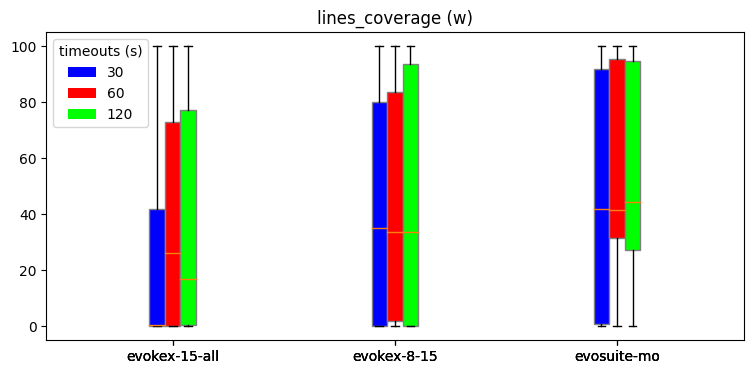

In [60]:
metric = 'lines_coverage'
weighted = True
project = None # or None

fig, ax = plt.subplots(figsize=(9, 4))

def get_stats(tool, timeout):
    stats = global_stats[tool][timeout] if project is None else global_stats[tool][timeout]['projects'][project]
    stats = stats['weighted'] if weighted else stats['default']
    return stats[metric]

draw_boxplots(ax, tools, timeouts, get_stats)

ax.legend(loc='upper left', title='timeouts (s)')
title = metric if project is None else f'{project}: {metric}'
if weighted:
    title += ' (w)'
ax.set_title(title)

plt.show()


In [32]:
def draw_per_project(metric, weighted, tool):
    fig, ax = plt.subplots(figsize=(9, 4))

    def get_stats(project, timeout):
        stats = global_stats[tool][timeout]['projects'][project]
        stats = stats['weighted'] if weighted else stats['default']
        return stats[metric]

    draw_boxplots(ax, projects, timeouts, get_stats, 0.15)

    ax.legend(loc='upper left', title='timeouts (s)', bbox_to_anchor=(1, 1))
    title = f'{tool}: {metric}'
    if weighted:
        title += ' (w)'
    ax.set_title(title)


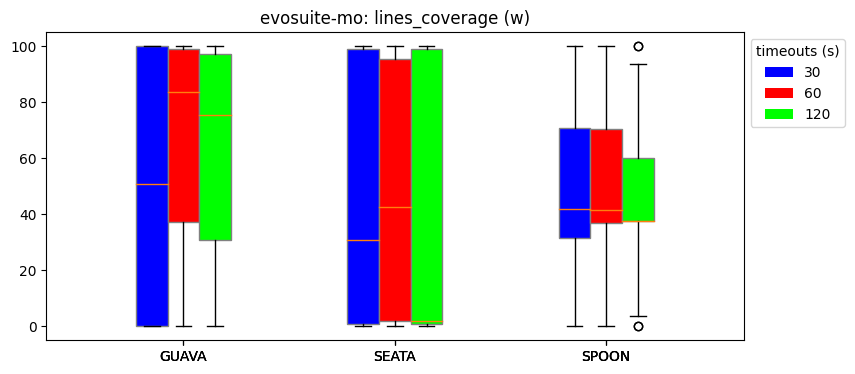

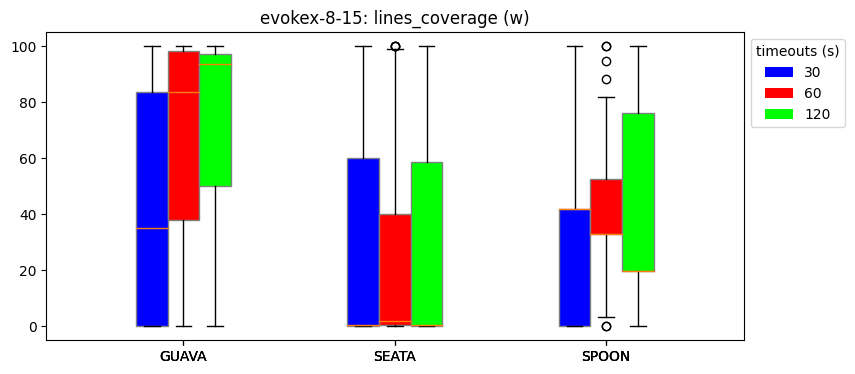

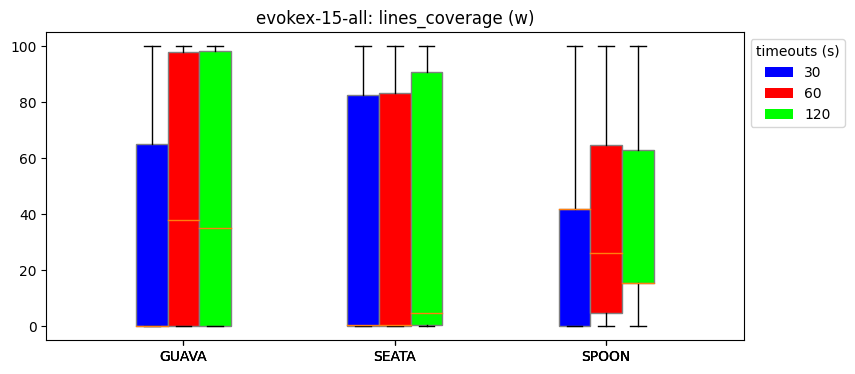

In [62]:
metric = 'lines_coverage'
weighted = True

draw_per_project(metric, weighted, 'evosuite-mo')
draw_per_project(metric, weighted, 'evokex-8-15')
draw_per_project(metric, weighted, 'evokex-15-all')
plt.show()

In [58]:
data_indexed[data_indexed['tool'] != 'evokex-15-all'].loc[:, 120, 'GUAVA'].groupby('cut').apply(lambda x: x[['lines_coverage_ratio', 'lines_total', 'benchmark']].sort_values(by='tool'))

lines_coverage_ratio  \
cut                                                tool                                
com.google.common.base.CaseFormat                  evokex-8-15            100.000000   
                                                   evosuite-mo            100.000000   
com.google.common.base.Throwables                  evokex-8-15              0.000000   
                                                   evosuite-mo              0.000000   
com.google.common.base.internal.Finalizer          evokex-8-15             16.923077   
                                                   evosuite-mo             16.923077   
com.google.common.collect.Queues                   evokex-8-15             81.333336   
                                                   evosuite-mo             72.000000   
com.google.common.collect.ReverseOrdering          evokex-8-15             66.666670   
                                                   evosuite-mo             71.428570   
com.google.common.collect.SparseImmutableTable     evokex-8-15             34.920635   
                                                   evosuite-mo             34.920635   
com.google.common.collect.TopKSelector             evokex-8-15             93.670880   
                                                   evosuite-mo             44.303800   
com.google.common.collect.TreeRangeMap             evokex-8-15             66.279070   
                                                   evosuite-mo             75.581400   
com.google.common.io.FileBackedOutputStream        evokex-8-15             96.000000   
                                                   evosuite-mo              0.000000   
com.google.common.math.IntMath                     evokex-8-15             97.222220   
                                                   evosuite-mo             97.222220   
com.google.common.math.PairedStatsAccumulator      evokex-8-15            100.000000   
                                                   evosuite-mo            100.000000   
com.google.common.primitives.Booleans              evokex-8-15            100.000000   
                                                   evosuite-mo            100.000000   
com.google.common.primitives.Shorts                evokex-8-15             99.029120   
                                                   evosuite-mo            100.000000   
com.google.common.util.concurrent.AtomicDoubleA... evokex-8-15              0.000000   
                                                   evosuite-mo             94.915250   
com.google.common.util.concurrent.SimpleTimeLim... evokex-8-15             50.000000   
                                                   evosuite-mo             30.909092   

                                                                lines_total  \
cut                                                tool                       
com.google.common.base.CaseFormat                  evokex-8-15           30   
                                                   evosuite-mo           30   
com.google.common.base.Throwables                  evokex-8-15           92   
                                                   evosuite-mo           92   
com.google.common.base.internal.Finalizer          evokex-8-15           65   
                                                   evosuite-mo           65   
com.google.common.collect.Queues                   evokex-8-15           75   
                                                   evosuite-mo           75   
com.google.common.collect.ReverseOrdering          evokex-8-15           21   
                                                   evosuite-mo           21   
com.google.common.collect.SparseImmutableTable     evokex-8-15           63   
                                                   evosuite-mo           63   
com.google.common.collect.TopKSelector             evokex-8-15           79   
                                                   evosuite-mo